# LineSink1D and LineDoublet1D


This notebook contains the examples of the LineSink1D and LineDoublet1D elements.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timml
from scipy.special import erfc

import ttim

plt.rcParams["figure.figsize"] = (10, 4)

Define the analytical solutions for 1D confined flow in a semi-infinite field.

In [2]:
def ierfc(z, n):
    if n == -1:
        return 2 / np.sqrt(np.pi) * np.exp(-z * z)
    elif n == 0:
        return erfc(z)
    else:
        result = -z / n * ierfc(z, n - 1) + 1 / (2 * n) * ierfc(z, n - 2)
        return np.clip(result, a_min=0.0, a_max=None)


def bruggeman_123_02(x, t, dh, k, H, S):
    """Solution for sudden rise of the water table in a confined aquifer.

    From Bruggeman 123.02
    """
    beta = np.sqrt(S / (k * H))
    u = beta * x / (2 * np.sqrt(t))
    return dh * erfc(u)


def bruggeman_123_03(x, t, a, k, H, S):
    """Solution for linear rise of the water table in a confined aquifer.

    From Bruggeman 123.03
    """
    beta = np.sqrt(S / (k * H))
    u = beta * x / (2 * np.sqrt(t))
    return a * t * ierfc(u, 2) / ierfc(0, 2)


def bruggeman_123_05_q(x, t, b, k, H, S):
    """Solution for constant infiltration/extraction in a confined aquifer.

    From Olsthoorn, Th. 2006. Van Edelman naar Bruggeman. Stromingen 12 (2006) p5-11.
    """
    beta = np.sqrt(S / (k * H))
    u = beta * x / (2 * np.sqrt(t))
    s = 2 * b * np.sqrt(t) / np.sqrt(k * H * S) * ierfc(u, 1) / (ierfc(0, 0))
    return s

In [3]:
# from Analyical Groundwater Modeling, ch. 5


def h_edelman(x, t, T, S, delh, t0=0.0):
    u = np.sqrt(S * x**2 / (4 * T * (t - t0)))
    return delh * erfc(u)


def Qx_edelman(x, t, T, S, delh, t0=0.0):
    u = np.sqrt(S * x**2 / (4 * T * (t - t0)))
    return T * delh * 2 * u / (x * np.sqrt(np.pi)) * np.exp(-(u**2))

Check implementation of the iterated integral complementary error function.

Compared to figure 3 in [Olsthoorn, (2006)](https://edepot.wur.nl/13730).

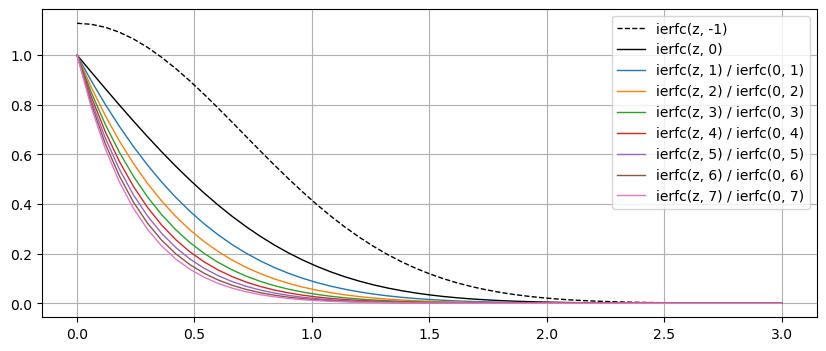

In [4]:
z = np.linspace(0, 3, 51)
ierfc_min1 = ierfc(z, -1)
ierfc0 = ierfc(z, 0)
plt.plot(z, ierfc_min1, ls="dashed", label="ierfc(z, -1)", lw=1.0, color="k")
plt.plot(z, ierfc0, ls="solid", label="ierfc(z, 0)", lw=1.0, color="k")
for n in range(1, 8):
    plt.plot(
        z, ierfc(z, n) / ierfc(0, n), label=f"ierfc(z, {n}) / ierfc(0, {n})", lw=1.0
    )
plt.legend()
plt.grid()

## Single layer confined aquifer

Example problem confined aquifer.

In [5]:
k = 5
H = 10
Ss = 1e-3 / H
Q = 2.0

In [6]:
mlconf = ttim.ModelMaq(
    kaq=k, z=[0, -H], Saq=Ss, tmin=1e-3, tmax=1e3, topboundary="conf"
)
ls = ttim.DischargeLineSink1D(mlconf, tsandq=[(0, Q)], layers=[0])
mlconf.solve()

self.neq  0
No unknowns. Solution complete


Plot head along $x$ for different times $t$. Compare to analytical solution.

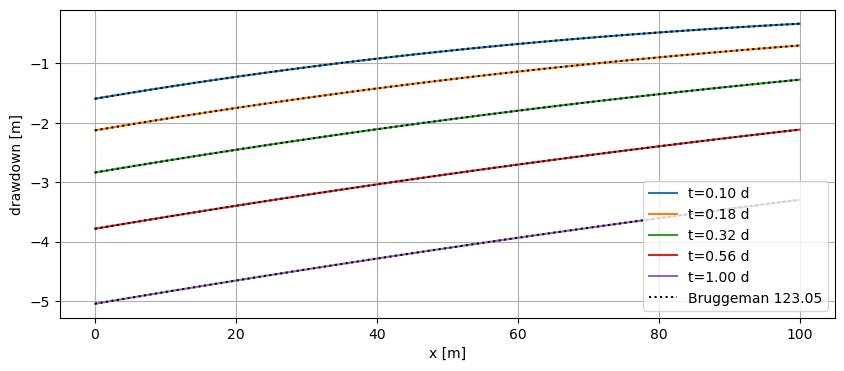

In [7]:
x = np.linspace(0, 100, 101)
y = np.zeros_like(x)
t = np.logspace(-1, 0, 5)

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.2f} d")
    ha = bruggeman_123_05_q(x, t[i], -Q / 2, k, H, Ss * H)  # Q/2 because 2-sided flow?
    plt.plot(x, ha, "k:")
plt.plot([], [], "k:", label="Bruggeman 123.05")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("drawdown [m]")
plt.grid()

## Single layer semi-confined aquifer

In [8]:
mlsemi = ttim.ModelMaq(
    kaq=k, z=[1, 0, -H], c=[10], tmin=1e-3, tmax=1e3, topboundary="semi"
)
ls = ttim.DischargeLineSink1D(mlsemi, tsandq=[(0, Q)], layers=[0])
mlsemi.solve()

self.neq  0
No unknowns. Solution complete


Compare to TimML steady-state solution

In [9]:
mlss = timml.ModelMaq(kaq=k, z=[1, 0, -H], c=[10], topboundary="semi", hstar=0.0)
ls = timml.LineSink1D(mlss, 0.0, sigls=Q)
mlss.solve()

Plot head along $x$ for different times $t$.

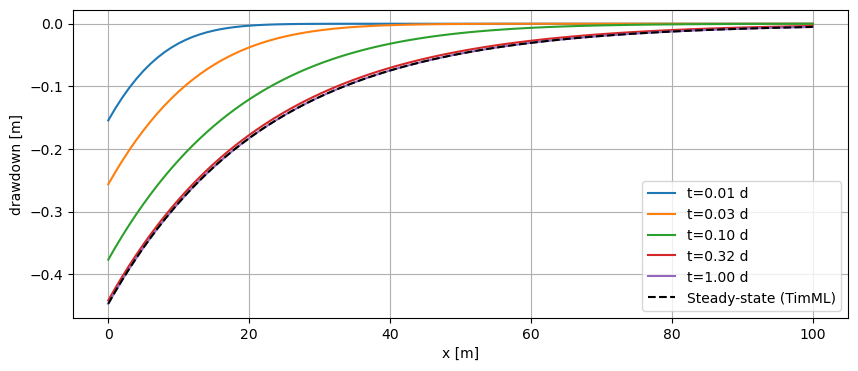

In [10]:
x = np.linspace(0, 100, 101)
y = np.zeros_like(x)
t = np.logspace(-2, 0, 5)

for i in range(len(t)):
    h = mlsemi.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.2f} d")

hss = mlss.headalongline(x, y)
plt.plot(x, hss.squeeze(), "k--", label="Steady-state (TimML)")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("drawdown [m]")
plt.grid()

## Sudden change in water level

In [11]:
# from Analyical Groundwater Modeling, ch. 5, p. 72
k = 10.0
H = 10.0
S = 0.2
delh = 2.0
t0 = 0.0

In [12]:
mlconf = ttim.ModelMaq(
    kaq=k, z=[0, -H], Saq=S, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls = ttim.HeadLineSink1D(mlconf, tsandh=[(0, delh)], layers=[0])
mlconf.solve()

self.neq  1
solution complete


Compute head along $x$ for t = 1, 10 and 100 days. Compare to analytical solution.

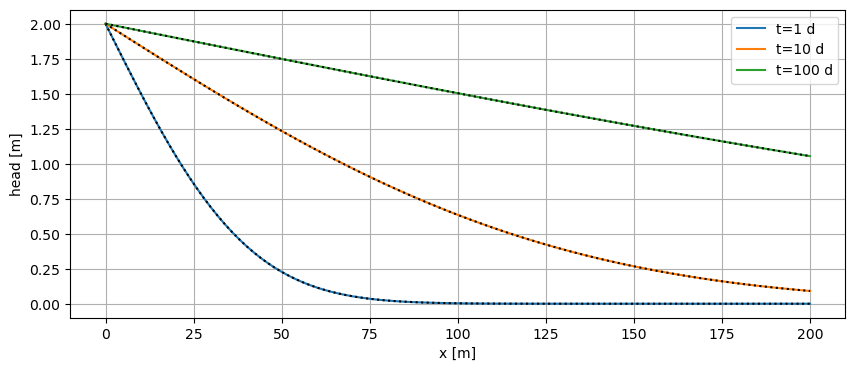

In [13]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.0f} d")
    ha = h_edelman(x, t[i], k * H, S, delh, t0)
    plt.plot(x, ha, "k:")

plt.legend()
plt.xlabel("x [m]")
plt.ylabel("head [m]")
plt.grid()

## Leaky Wall

Use the previous problem but add a leaky wall at x=100 m with resistance 10 days.

In [14]:
# from Analyical Groundwater Modeling, ch. 5, p. 72
k = 10.0
H = 10.0
S = 0.2
delh = 2.0
t0 = 0.0

# add leaky wall with resistance
res = 10.0

In [15]:
mlconf = ttim.ModelMaq(
    kaq=k, z=[0, -H], Saq=S, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls = ttim.HeadLineSink1D(mlconf, xls=0.0, tsandh=[(0, delh)], layers=[0])
ld = ttim.LeakyLineDoublet1D(mlconf, xld=100.0, res=res, layers=[0])
mlconf.solve()

self.neq  2
solution complete


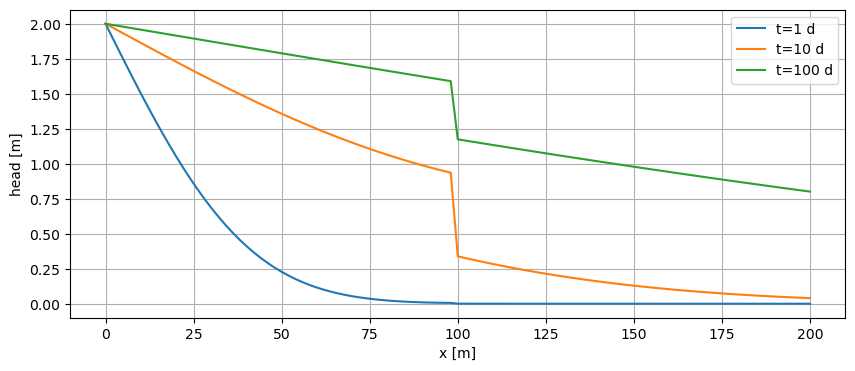

In [16]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    plt.plot(x, h.squeeze(), label=f"t={t[i]:.0f} d")

plt.legend()
plt.xlabel("x [m]")
plt.ylabel("head [m]")
plt.grid()

## Multi-layer system

In [17]:
z = [0.0, - 5.0, -6.0, -15.0]
Saq = [0.2, 1e-4]
c = [10.0]
k = [5.0, 10.0]
delh = 1.0
res = 10.0

In [31]:
mlconf = ttim.ModelMaq(
    kaq=k, z=z, Saq=Saq, c=c, tmin=1, tmax=1e2, topboundary="conf", phreatictop=True
)
hls_left = ttim.HeadLineSink1D(mlconf, xls=0.0, tsandh=[(0, delh)], layers=[0, 1])
hls_right = ttim.HeadLineSink1D(mlconf, xls=200.0, tsandh=[(0, 0.0)], layers=[0, 1])
ld = ttim.LeakyLineDoublet1D(mlconf, xld=100.0, res=res, layers=[0])
mlconf.solve()

self.neq  5
solution complete


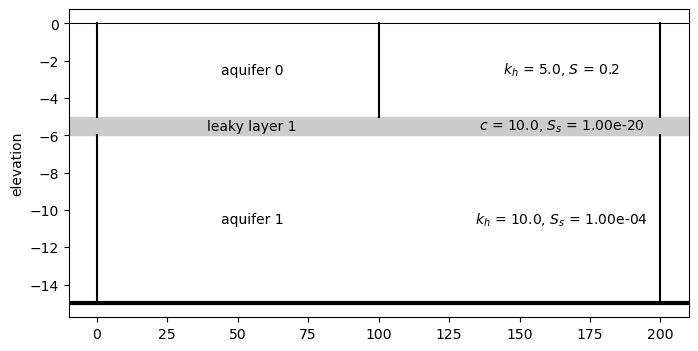

In [32]:
ax = mlconf.plots.xsection([(-10, 0), (210, 0)], params=True)
for e in mlconf.elementlist:
    e.plot(ax=ax)
ax.set_xlim(-10, 210);

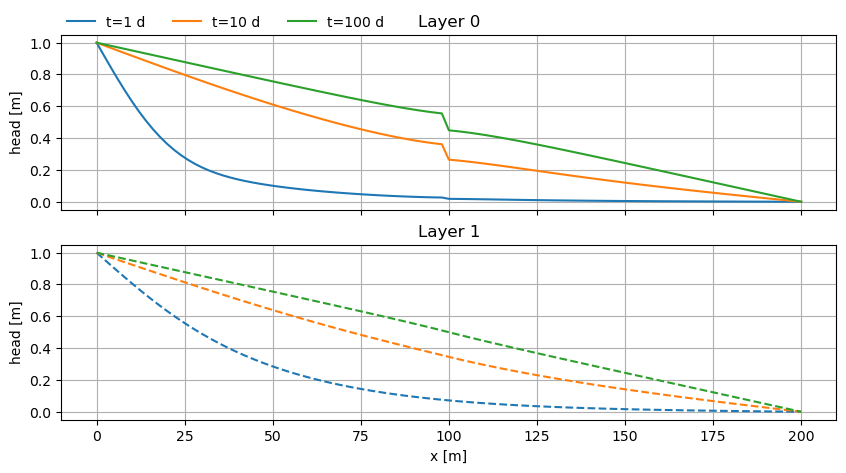

In [33]:
x = np.linspace(0, 200, 101)
y = np.zeros_like(x)
t = np.logspace(0, 2, 3)

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 5))

for i in range(len(t)):
    h = mlconf.headalongline(x, y, t[i])
    ax0.plot(x, h[0].squeeze(), label=f"t={t[i]:.0f} d")
    ax1.plot(x, h[1].squeeze(), label=f"t={t[i]:.0f} d", ls="dashed")

ax0.legend(loc=(0, 1), frameon=False, ncol=3)
ax0.set_title("Layer 0")
ax1.set_xlabel("x [m]")
ax1.set_title("Layer 1")
for iax in [ax0, ax1]:
    iax.set_ylabel("head [m]")
    iax.grid()